In [41]:
import numpy as np 
import pandas as pd
from scipy import ndimage 
from scipy.cluster import hierarchy 
from scipy.spatial import distance_matrix 
from matplotlib import pyplot as plt 
from sklearn import manifold, datasets 
from sklearn.cluster import AgglomerativeClustering 
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
%matplotlib inline

In [5]:
solar_df = pd.read_csv("Plant_1_Generation_Data.csv")
solar_df.head()

,DATE_TIME,PLANT_ID,SOURCE_KEY,DC_POWER,AC_POWER,DAILY_YIELD,TOTAL_YIELD
0,15-05-2020 00:00,4135001,1BY6WEcLGh8j5v7,0.0,0.0,0.0,6259559.0
1,15-05-2020 00:00,4135001,1IF53ai7Xc0U56Y,0.0,0.0,0.0,6183645.0
2,15-05-2020 00:00,4135001,3PZuoBAID5Wc2HD,0.0,0.0,0.0,6987759.0
3,15-05-2020 00:00,4135001,7JYdWkrLSPkdwr4,0.0,0.0,0.0,7602960.0
4,15-05-2020 00:00,4135001,McdE0feGgRqW7Ca,0.0,0.0,0.0,7158964.0


In [6]:
print(solar_df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 68778 entries, 0 to 68777
Data columns (total 7 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   DATE_TIME    68778 non-null  object 
 1   PLANT_ID     68778 non-null  int64  
 2   SOURCE_KEY   68778 non-null  object 
 3   DC_POWER     68778 non-null  float64
 4   AC_POWER     68778 non-null  float64
 5   DAILY_YIELD  68778 non-null  float64
 6   TOTAL_YIELD  68778 non-null  float64
dtypes: float64(4), int64(1), object(2)
memory usage: 3.7+ MB
None


In [8]:
print(solar_df.isnull().sum())

DATE_TIME      0
PLANT_ID       0
SOURCE_KEY     0
DC_POWER       0
AC_POWER       0
DAILY_YIELD    0
TOTAL_YIELD    0
dtype: int64


In [10]:
df_cleaned = solar_df.dropna()

In [52]:
print("Missing values per column:\n", solar_df.isnull().sum())

solar_df['DC_POWER'].replace(0, np.nan, inplace=True)
solar_df['AC_POWER'].replace(0, np.nan, inplace=True)

solar_df['DC_POWER'] = solar_df['DC_POWER'].interpolate(method='linear', limit_direction='both')
solar_df['AC_POWER'] = solar_df['AC_POWER'].interpolate(method='linear', limit_direction='both')

solar_df['EXPECTED_YIELD'] = solar_df['TOTAL_YIELD'].diff().fillna(0)
solar_df['EXPECTED_YIELD'].clip(lower=0, inplace=True) 

solar_df['DAILY_YIELD'] = solar_df['DAILY_YIELD'].fillna(solar_df['EXPECTED_YIELD'])
solar_df = solar_df.drop_duplicates(subset=['DATE_TIME', 'PLANT_ID', 'SOURCE_KEY'])

solar_df.to_csv('cleaned_solar_data.csv', index=False)

Missing values per column:
 DATE_TIME         0
PLANT_ID          0
SOURCE_KEY        0
DC_POWER          0
AC_POWER          0
DAILY_YIELD       0
TOTAL_YIELD       0
EXPECTED_YIELD    0
dtype: int64


In [53]:

X = solar_df[['AC_POWER', 'DAILY_YIELD', 'TOTAL_YIELD']] 
y = solar_df['DC_POWER']  

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train_scaled, y_train)

y_pred = model.predict(X_test_scaled)
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print("Model Evaluation Metrics:")
print(f"Mean Absolute Error (MAE): {mae}")
print(f"Mean Squared Error (MSE): {mse}")
print(f"R² Score: {r2}")
joblib.dump(model, 'solar_power_model.pkl')
print("Model saved as solar_power_model.pkl")
joblib.dump(scaler, 'scaler.pkl')
print("Scaler saved as scaler.pkl")

Model Evaluation Metrics:
Mean Absolute Error (MAE): 1.5662691105169044
Mean Squared Error (MSE): 142.6912450516097
R² Score: 0.9999910379393989
Model saved as solar_power_model.pkl
Scaler saved as scaler.pkl


In [42]:

X = solar_df[['AC_POWER', 'DAILY_YIELD', 'TOTAL_YIELD']]  
y = solar_df['DC_POWER']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

results = {}


lr_model = LinearRegression()
lr_model.fit(X_train_scaled, y_train)
y_pred_lr = lr_model.predict(X_test_scaled)

results['Linear Regression'] = {
    'MAE': mean_absolute_error(y_test, y_pred_lr),
    'MSE': mean_squared_error(y_test, y_pred_lr),
    'R2': r2_score(y_test, y_pred_lr)
}

mlp_model = MLPRegressor(hidden_layer_sizes=(64, 32), activation='relu', max_iter=500, random_state=42)
mlp_model.fit(X_train_scaled, y_train)
y_pred_mlp = mlp_model.predict(X_test_scaled)

results['Neural Network (MLP)'] = {
    'MAE': mean_absolute_error(y_test, y_pred_mlp),
    'MSE': mean_squared_error(y_test, y_pred_mlp),
    'R2': r2_score(y_test, y_pred_mlp)
}

for model, metrics in results.items():
    print(f"{model} Metrics:")
    print(f"  Mean Absolute Error (MAE): {metrics['MAE']}")
    print(f"  Mean Squared Error (MSE): {metrics['MSE']}")
    print(f"  R² Score: {metrics['R2']}")
    print("-" * 30)

Linear Regression Metrics:
  Mean Absolute Error (MAE): 7.576123502490469
  Mean Squared Error (MSE): 228.13719725205388
  R² Score: 0.9999856713045961
------------------------------
Neural Network (MLP) Metrics:
  Mean Absolute Error (MAE): 2.49532796416084
  Mean Squared Error (MSE): 145.7722273218617
  R² Score: 0.9999908444310318
------------------------------


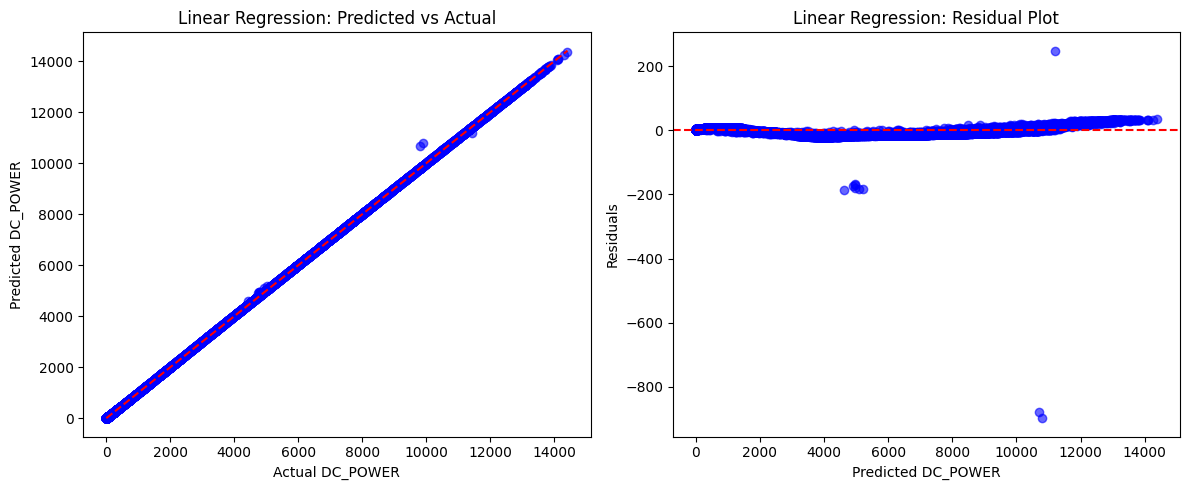

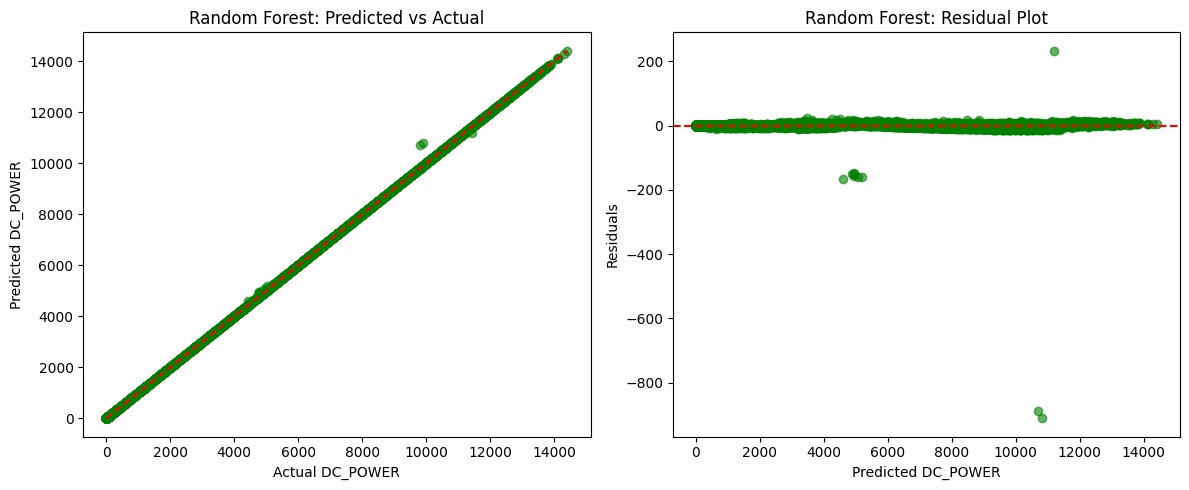

Best model saved as 'best_model.pkl'


In [50]:
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.scatter(y_test, y_pred_lr, color='blue', alpha=0.6)
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red', linestyle='--')
plt.title('Linear Regression: Predicted vs Actual')
plt.xlabel('Actual DC_POWER')
plt.ylabel('Predicted DC_POWER')

plt.subplot(1, 2, 2)
plt.scatter(y_pred_lr, y_test - y_pred_lr, color='blue', alpha=0.6)
plt.axhline(y=0, color='red', linestyle='--')
plt.title('Linear Regression: Residual Plot')
plt.xlabel('Predicted DC_POWER')
plt.ylabel('Residuals')

plt.tight_layout()
plt.show()


plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.scatter(y_test, y_pred_mlp, color='green', alpha=0.6)
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red', linestyle='--')
plt.title('Random Forest: Predicted vs Actual')
plt.xlabel('Actual DC_POWER')
plt.ylabel('Predicted DC_POWER')

plt.subplot(1, 2, 2)
plt.scatter(y_pred_mlp, y_test - y_pred_mlp, color='green', alpha=0.6)
plt.axhline(y=0, color='red', linestyle='--')
plt.title('Random Forest: Residual Plot')
plt.xlabel('Predicted DC_POWER')
plt.ylabel('Residuals')

plt.tight_layout()
plt.show()
best_model = y_pred_mlp if results['Neural Network (MLP)']['R2'] > results['Linear Regression']['R2'] else lr_model
joblib.dump(best_model, 'best_model.pkl')
print("'best_model.pkl'")